# Probabilistic machine learning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set()

## Ensemble XGBoost for regression

In [2]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

/mnt/c/Users/jwilliams/Documents/GitHub/probablistic_deep_learning/env/lib/python3.9/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


### Usecase 1

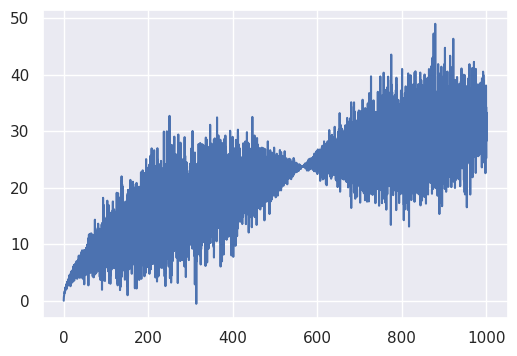

In [3]:
start = 0
stop = 1000
dx = 0.1
#dx = 1

x = np.arange(start, stop, dx)
y_clean = x**0.5

n_samples = len(x)

a = 5
noise_amp = a * np.abs(np.sin(x/180))
noise = noise_amp * np.random.randn(n_samples)

y = y_clean + noise

plt.figure(figsize=(6,4))
plt.plot(x,y)
plt.show()

**Make many XGBRegressors**

In [7]:
x = x.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [8]:
n_regessors = 2000
regressors = []
np.random.seed(2049)

for n in tqdm(range(n_regessors)):
    seed = np.random.randint(100000)
    
    # Take a subset of the training data
    X_train_sub1, X_train_sub2, y_train_sub1, y_train_sub2 = train_test_split(X_train, y_train, test_size=0.98, random_state=seed)
    
    reg = XGBRegressor(n_estimators=30, max_depth=6, random_state=seed)
    reg.fit(X_train_sub1, y_train_sub1)
    regressors.append(reg)

df_results = pd.DataFrame({'x':X_test.flatten()})

print("Testing")
for idx, reg in enumerate(regressors):
    y_pred = reg.predict(X_test)
    df_results["pred{}".format(idx)] = y_pred
    
df_results.sort_values('x', inplace=True)
df_results.set_index('x', inplace=True)
mean = df_results.mean(axis=1)
std = df_results.std(axis=1)

df_results['pred_mean'] = mean
df_results['pred_std'] = std

print("Finished")

100%|███████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:53<00:00, 37.38it/s]


Testing


/tmp/ipykernel_960/1995977141.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df_results["pred{}".format(idx)] = y_pred


Finished


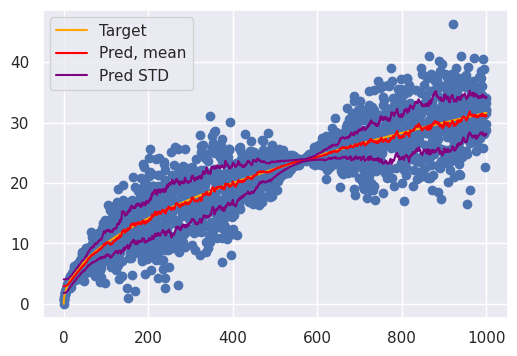

In [12]:
plt.figure(figsize=(6,4))
plt.scatter(X_test, y_test)
#plt.scatter(X_train_sub1, y_train_sub1)
plt.plot(x, y_clean, color='orange', label='Target')
plt.plot(df_results.index, df_results.pred_mean, color='red', label='Pred, mean')
plt.plot(df_results.index, df_results.pred_mean+df_results.pred_std, color='purple', label='Pred STD')
plt.plot(df_results.index, df_results.pred_mean-df_results.pred_std, color='purple')
plt.legend()
plt.show()

### Usecase 2: Non-linear RUL

In [29]:
def func(x, a, b, c, noise_amp = 0):
    y = a*x**b + c

    if noise_amp == 0:
        y = y
    else:
        y = y + noise_amp * np.random.randn(len(x))
    
    return y

**Parameter ranges**

In [104]:
x = np.arange(0,10,0.1)
a_range = (0, 2)
b_range = (1, 1.5)
c_range = (0, 10)
noise_range = (0,5)

**Test XGBRegressor ability to predict without noise**

In [105]:
# Create training and test data
np.random.seed(2049)
n_observations = 2000
a_list = np.random.rand(n_observations)*(a_range[1] - a_range[0]) + a_range[0]
b_list = np.random.rand(n_observations)*(b_range[1] - b_range[0]) + b_range[0]
c_list = np.random.rand(n_observations)*(c_range[1] - c_range[0]) + c_range[0]

targets = np.array(list(zip(a_list,b_list,c_list)))
features = np.array([func(x,a,b,c) for a, b, c in targets])

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=2049)

In [106]:
reg = XGBRegressor()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

In [107]:
from sklearn.metrics import mean_squared_error
score = mean_squared_error(y_test, y_pred)
print(score)

0.007291536454173103


This shows that the model is working correctly.

**Now let's make many models**, but also add noise

In [108]:
n_regessors = 100
n_training_obs = 1000
regressors = []
np.random.seed(2049)

for n in tqdm(range(n_regessors)):
    seed = np.random.randint(100000)

    a_list = np.random.rand(n_training_obs)*(a_range[1] - a_range[0]) + a_range[0]
    b_list = np.random.rand(n_training_obs)*(b_range[1] - b_range[0]) + b_range[0]
    c_list = np.random.rand(n_training_obs)*(c_range[1] - c_range[0]) + c_range[0]
    noise_list = np.random.rand(n_training_obs)*(noise_range[1] - noise_range[0]) + noise_range[0]

    targets = np.array(list(zip(a_list,b_list,c_list)))
    targets_with_noise = np.array(list(zip(a_list,b_list,c_list,noise_list)))
    features = np.array([func(x,a,b,c,noise) for a, b, c, noise in targets_with_noise])

    reg = XGBRegressor(random_state=seed)
    reg.fit(features, targets)
    regressors.append(reg)

print('Done')

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [05:36<00:00,  3.37s/it]

Done


**Make a test set and predict**

In [112]:
seed = np.random.randint(100000)
a_list = np.random.rand(n_training_obs)*(a_range[1] - a_range[0]) + a_range[0]
b_list = np.random.rand(n_training_obs)*(b_range[1] - b_range[0]) + b_range[0]
c_list = np.random.rand(n_training_obs)*(c_range[1] - c_range[0]) + c_range[0]
noise_list = np.random.rand(n_training_obs)*(noise_range[1] - noise_range[0]) + noise_range[0]

targets = np.array(list(zip(a_list,b_list,c_list)))
targets_with_noise = np.array(list(zip(a_list,b_list,c_list,noise_list)))
features = np.array([func(x,a,b,c,noise) for a, b, c, noise in targets_with_noise])

a_pred = []
b_pred = []
c_pred = []

for reg in tqdm(regressors):
    result = reg.predict(features)
    a, b, c = result.T
    a_pred.append(a)
    b_pred.append(b)
    c_pred.append(c)

a_pred = np.array(a_pred).T
b_pred = np.array(b_pred).T
c_pred = np.array(c_pred).T

a_mean = a_pred.mean(axis=1)
b_mean = b_pred.mean(axis=1)
c_mean = c_pred.mean(axis=1)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 366.81it/s]


In [113]:
noise_list[:10]

array([3.39557625, 4.66875987, 0.89141328, 3.84789266, 3.0434109 ,
       0.5564    , 1.77720173, 3.37821596, 4.9384925 , 1.32855341])

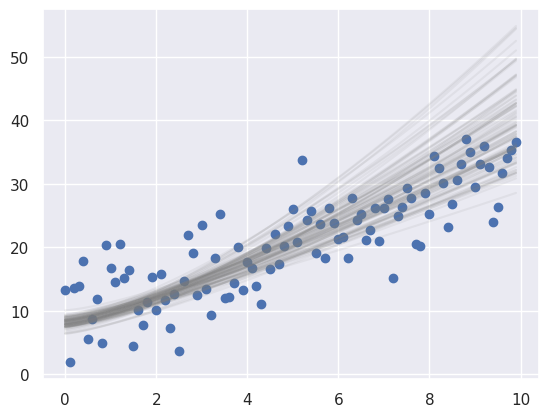

In [117]:
idx = 1

for idx_reg in range(n_regessors):

    plt.plot(x, func(x, a_pred[idx][idx_reg], b_pred[idx][idx_reg], c_pred[idx][idx_reg]), color='grey', alpha=0.1)

plt.scatter(x, features[idx])
plt.show()

(array([105.,  94., 110., 109.,  94.,  95.,  97., 108.,  82., 106.]),
 array([3.70379589e-03, 5.02903842e-01, 1.00210389e+00, 1.50130393e+00,
        2.00050398e+00, 2.49970403e+00, 2.99890407e+00, 3.49810412e+00,
        3.99730417e+00, 4.49650421e+00, 4.99570426e+00]),
 <BarContainer object of 10 artists>)

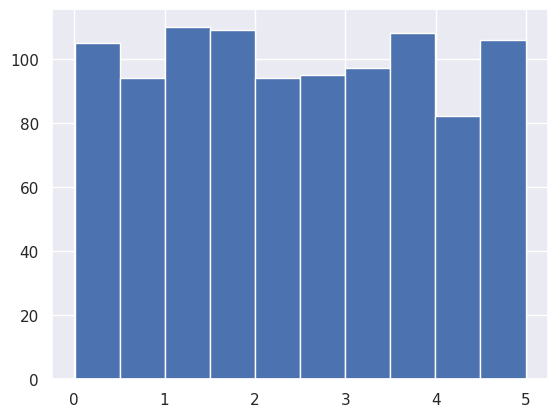

In [118]:
plt.hist(noise_list)

In [119]:
reg

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=75354, ...)

#### Refine the regressor

In [120]:
n_regessors = 100
n_training_obs = 1000
regressors = []
np.random.seed(2049)

for n in tqdm(range(n_regessors)):
    seed = np.random.randint(100000)

    a_list = np.random.rand(n_training_obs)*(a_range[1] - a_range[0]) + a_range[0]
    b_list = np.random.rand(n_training_obs)*(b_range[1] - b_range[0]) + b_range[0]
    c_list = np.random.rand(n_training_obs)*(c_range[1] - c_range[0]) + c_range[0]
    noise_list = np.random.rand(n_training_obs)*(noise_range[1] - noise_range[0]) + noise_range[0]

    targets = np.array(list(zip(a_list,b_list,c_list)))
    targets_with_noise = np.array(list(zip(a_list,b_list,c_list,noise_list)))
    features = np.array([func(x,a,b,c,noise) for a, b, c, noise in targets_with_noise])

    reg = XGBRegressor(n_estimators=30, max_depth=6, random_state=seed)
    reg.fit(features, targets)
    regressors.append(reg)

print('Done')

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]

Done


In [121]:
a_pred = []
b_pred = []
c_pred = []

for reg in tqdm(regressors):
    result = reg.predict(features)
    a, b, c = result.T
    a_pred.append(a)
    b_pred.append(b)
    c_pred.append(c)

a_pred = np.array(a_pred).T
b_pred = np.array(b_pred).T
c_pred = np.array(c_pred).T

a_mean = a_pred.mean(axis=1)
b_mean = b_pred.mean(axis=1)
c_mean = c_pred.mean(axis=1)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 173.82it/s]


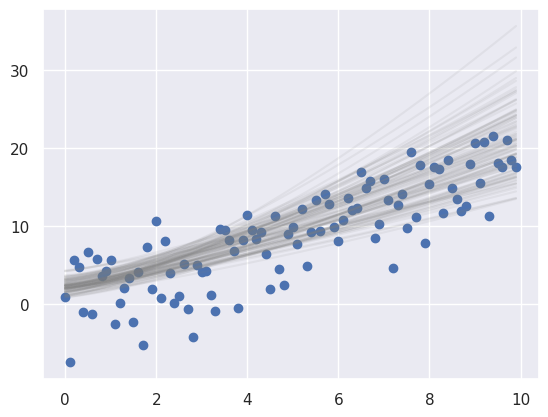

In [122]:
idx = 1

for idx_reg in range(n_regessors):

    plt.plot(x, func(x, a_pred[idx][idx_reg], b_pred[idx][idx_reg], c_pred[idx][idx_reg]), color='grey', alpha=0.1)

plt.scatter(x, features[idx])
plt.show()

## Usecase: linear RUL

In [123]:
# Define linear function
def func(x, a, c, noise_amp = 0):
    y = a*x + c
    y = y + noise_amp * np.random.randn(len(x))
    return y

# Set parameter limits
x = np.arange(0,10,0.1)
a_range = (0, 2)
c_range = (0, 10)
noise_range = (0,5)

In [125]:
# Train the model

n_regessors = 100
n_training_obs = 1000
regressors = []
np.random.seed(2049)

for n in tqdm(range(n_regessors)):
    seed = np.random.randint(100000)

    a_list = np.random.rand(n_training_obs)*(a_range[1] - a_range[0]) + a_range[0]
    c_list = np.random.rand(n_training_obs)*(c_range[1] - c_range[0]) + c_range[0]
    noise_list = np.random.rand(n_training_obs)*(noise_range[1] - noise_range[0]) + noise_range[0]

    targets = np.array(list(zip(a_list,c_list)))
    targets_with_noise = np.array(list(zip(a_list,c_list,noise_list)))
    features = np.array([func(x,a,c,noise) for a, c, noise in targets_with_noise])

    reg = XGBRegressor(random_state=seed)
    reg.fit(features, targets)
    regressors.append(reg)

print('Done')

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [05:27<00:00,  3.28s/it]

Done


In [127]:
seed = np.random.randint(100000)
a_list = np.random.rand(n_training_obs)*(a_range[1] - a_range[0]) + a_range[0]
c_list = np.random.rand(n_training_obs)*(c_range[1] - c_range[0]) + c_range[0]
noise_list = np.random.rand(n_training_obs)*(noise_range[1] - noise_range[0]) + noise_range[0]

targets = np.array(list(zip(a_list,c_list)))
targets_with_noise = np.array(list(zip(a_list,c_list,noise_list)))
features = np.array([func(x,a,c,noise) for a, c, noise in targets_with_noise])

a_pred = []
c_pred = []

for reg in tqdm(regressors):
    result = reg.predict(features)
    a, c = result.T
    a_pred.append(a)
    c_pred.append(c)

a_pred = np.array(a_pred).T
c_pred = np.array(c_pred).T

a_mean = a_pred.mean(axis=1)
c_mean = c_pred.mean(axis=1)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 285.37it/s]


In [128]:
noise_list[:10]

array([0.3261731 , 2.51534789, 0.35975976, 4.5648592 , 1.74863966,
       4.43606941, 0.48246734, 2.81923947, 2.65895182, 3.73467818])

In [159]:
from scipy.stats import norm

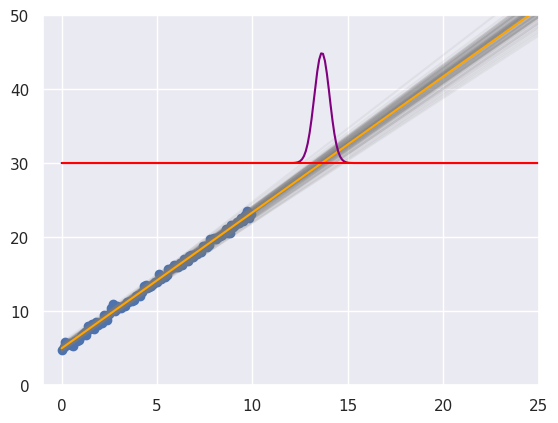

In [182]:
idx = 0

limit = 30
x30 = np.arange(0,30,0.1)
rul_list = []

for idx_reg in range(n_regessors):
    y_pred_idx = func(x30, a_pred[idx][idx_reg], c_pred[idx][idx_reg])
    plt.plot(x30, y_pred_idx, color='grey', alpha=0.1)
    idx_rul = np.abs(y_pred_idx - limit).argmin()
    rul = x30[idx_rul]
    rul_list.append(rul)

y_pred_mean = func(x30, a_mean[idx], c_mean[idx])
plt.plot(x30, y_pred_mean, color='orange')

rul_list = np.array(rul_list)
rul_mean = rul_list.mean()
rul_std = rul_list.std()
rul_pdf = norm.pdf(x30, rul_mean, rul_std)
plt.plot(x30, (rul_pdf*15)+30, color='purple')

plt.hlines(limit, 0, 30, color='red')
plt.scatter(x, features[idx])

plt.xlim(-1,25)
plt.ylim(0,50)
plt.show()

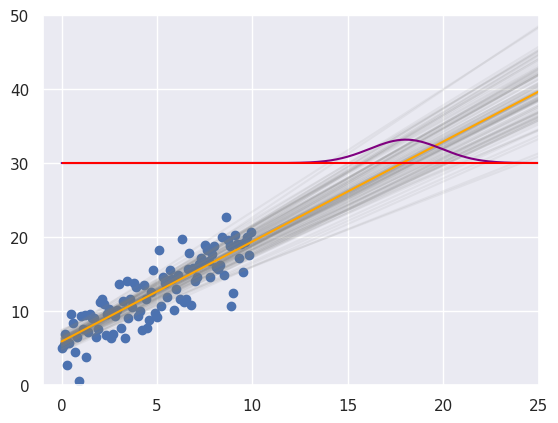

In [181]:
idx = 1

limit = 30
x30 = np.arange(0,30,0.1)
rul_list = []

for idx_reg in range(n_regessors):
    y_pred_idx = func(x30, a_pred[idx][idx_reg], c_pred[idx][idx_reg])
    plt.plot(x30, y_pred_idx, color='grey', alpha=0.1)
    idx_rul = np.abs(y_pred_idx - limit).argmin()
    rul = x30[idx_rul]
    rul_list.append(rul)

y_pred_mean = func(x30, a_mean[idx], c_mean[idx])
plt.plot(x30, y_pred_mean, color='orange')

rul_list = np.array(rul_list)
rul_mean = rul_list.mean()
rul_std = rul_list.std()
rul_pdf = norm.pdf(x30, rul_mean, rul_std)
plt.plot(x30, (rul_pdf*15)+30, color='purple')

plt.hlines(limit, 0, 30, color='red')
plt.scatter(x, features[idx])

plt.xlim(-1,25)
plt.ylim(0,50)
plt.show()

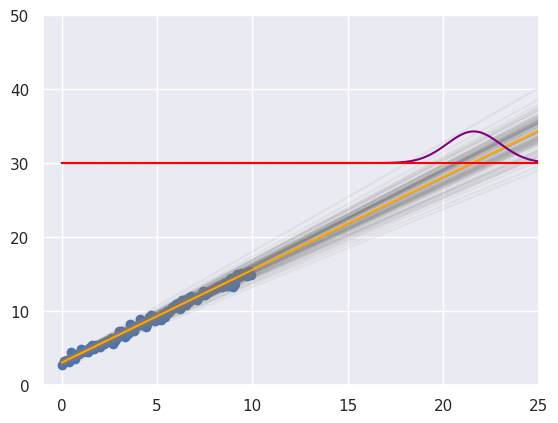

In [183]:
idx = 2

limit = 30
x30 = np.arange(0,30,0.1)
rul_list = []

for idx_reg in range(n_regessors):
    y_pred_idx = func(x30, a_pred[idx][idx_reg], c_pred[idx][idx_reg])
    plt.plot(x30, y_pred_idx, color='grey', alpha=0.1)
    idx_rul = np.abs(y_pred_idx - limit).argmin()
    rul = x30[idx_rul]
    rul_list.append(rul)

y_pred_mean = func(x30, a_mean[idx], c_mean[idx])
plt.plot(x30, y_pred_mean, color='orange')

rul_list = np.array(rul_list)
rul_mean = rul_list.mean()
rul_std = rul_list.std()
rul_pdf = norm.pdf(x30, rul_mean, rul_std)
plt.plot(x30, (rul_pdf*15)+30, color='purple')

plt.hlines(limit, 0, 30, color='red')
plt.scatter(x, features[idx])

plt.xlim(-1,25)
plt.ylim(0,50)
plt.show()

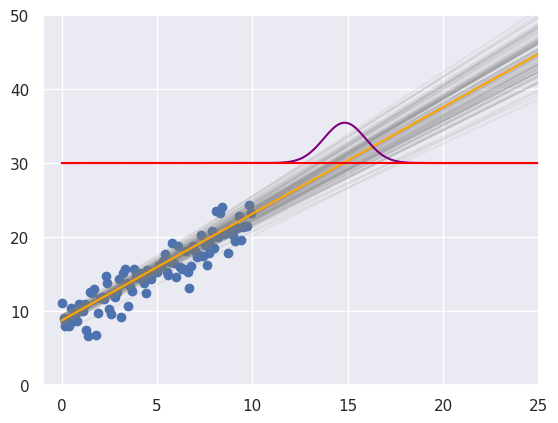

In [185]:
idx = 4

limit = 30
x30 = np.arange(0,30,0.1)
rul_list = []

for idx_reg in range(n_regessors):
    y_pred_idx = func(x30, a_pred[idx][idx_reg], c_pred[idx][idx_reg])
    plt.plot(x30, y_pred_idx, color='grey', alpha=0.1)
    idx_rul = np.abs(y_pred_idx - limit).argmin()
    rul = x30[idx_rul]
    rul_list.append(rul)

y_pred_mean = func(x30, a_mean[idx], c_mean[idx])
plt.plot(x30, y_pred_mean, color='orange')

rul_list = np.array(rul_list)
rul_mean = rul_list.mean()
rul_std = rul_list.std()
rul_pdf = norm.pdf(x30, rul_mean, rul_std)
plt.plot(x30, (rul_pdf*15)+30, color='purple')

plt.hlines(limit, 0, 30, color='red')
plt.scatter(x, features[idx])

plt.xlim(-1,25)
plt.ylim(0,50)
plt.show()

**Correlate std to error**

In [196]:
rul_true_list = []
rul_mean_list = []
rul_std_list = []
x100 = np.arange(0, 100, 0.1)
limit = 30

for idx, a in tqdm(enumerate(a_list)):
    # Find the true RUL
    c = c_list[idx]
    y_true = func(x100, a, c)
    rul_true = x100[np.abs(y_true - limit).argmin()]
    rul_true_list.append(rul_true)

    # Calculate the probabilitic 
    rul_discrete_dist = []
    for idx_reg in range(n_regessors):
        y_pred_idx = func(x100, a_pred[idx][idx_reg], c_pred[idx][idx_reg])
        idx_rul = np.abs(y_pred_idx - limit).argmin()
        rul = x100[idx_rul]
        rul_discrete_dist.append(rul)
    
    rul_mean_list.append(np.mean(rul_discrete_dist))
    rul_std_list.append(np.std(rul_discrete_dist))

1000it [00:05, 199.40it/s]


In [227]:
data = {'noise':noise_list, 'rul_true':rul_true_list, 'rul_pred_mean':rul_mean_list, 'rul_pred_std':rul_std_list}
df = pd.DataFrame(data)
df['rul_pred_error'] = df.rul_pred_mean - df.rul_true
df['rul_pred_error_abs'] = df.rul_pred_error.abs()

# remove ruls that are very far in the future
df = df.loc[df.rul_true <= 80, :]
df.reset_index(drop=True, inplace=True)

df

,noise,rul_true,rul_pred_mean,rul_pred_std,rul_pred_error,rul_pred_error_abs
0,0.326173,13.7,13.644,0.401079,-0.056,0.056
1,2.515348,18.3,18.037,1.889849,-0.263,0.263
2,0.359760,22.0,21.599,1.398320,-0.401,0.401
3,1.748640,16.4,14.834,1.096651,-1.566,1.566
4,4.436069,28.0,34.983,7.998876,6.983,6.983
...,...,...,...,...,...,...
848,0.456606,27.9,28.516,2.290053,0.616,0.616
849,0.787275,19.6,19.412,1.494475,-0.188,0.188
850,3.398403,79.7,89.242,14.501498,9.542,9.542
851,3.294478,29.3,27.454,4.967624,-1.846,1.846


/tmp/ipykernel_960/242634322.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colorbar = plt.colorbar(label='Noise')


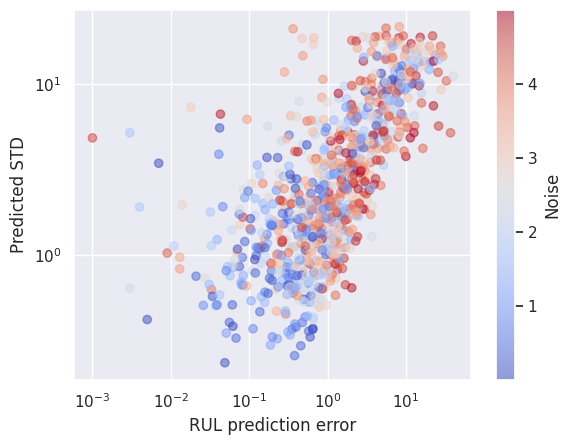

In [228]:
x = df.rul_pred_error_abs
y = df.rul_pred_std
z = df.noise
plt.scatter(x, y, c=z, cmap='coolwarm', alpha=0.5)
colorbar = plt.colorbar(label='Noise')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('RUL prediction error')
plt.ylabel('Predicted STD')
plt.show()

/tmp/ipykernel_960/242634322.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colorbar = plt.colorbar(label='Noise')


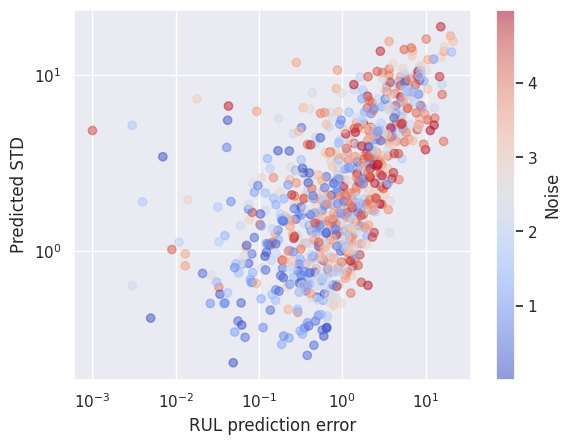

In [220]:
x = df.rul_pred_error_abs
y = df.rul_pred_std
z = df.noise
plt.scatter(x, y, c=z, cmap='coolwarm', alpha=0.5)
colorbar = plt.colorbar(label='Noise')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('RUL prediction error')
plt.ylabel('Predicted STD')
plt.show()